In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/surface-crack-detection'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.layers import Input,Flatten,Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from glob import glob

In [3]:
# Constants
input_directory = '/kaggle/input/surface-crack-detection'
image_size = (227, 227)

In [6]:
IMAGE_SIZE=224
BATCH_SIZE=64

train_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    
    
    rescale=1./255,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1)

validation_datagen=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    
    validation_split=0.1
)

In [8]:


train_genarator=train_datagen.flow_from_directory(
    input_directory,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='training'
    

) 

validation_generator=validation_datagen.flow_from_directory(
    input_directory,
    target_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    subset='validation'
    

) 
    



Found 36000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.


In [10]:


IMAGE_SIZE=[227,227]
vgg=VGG16(input_shape=IMAGE_SIZE+[3],weights='imagenet',include_top=False)
vgg.output



58889256/58889256 [==============================] - 0s 0us/step


<KerasTensor: shape=(None, 7, 7, 512) dtype=float32 (created by layer 'block5_pool')>

In [11]:
for layer in vgg.layers:
    layer.trainable=False

In [12]:


x=Flatten()(vgg.output)
prediction=Dense(2,activation='softmax')(x)
model=Model(inputs=vgg.input,outputs=prediction)
model.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 227, 227, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 227, 227, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 227, 227, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 113, 113, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 113, 113, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 113, 113, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [14]:
epoch=10

history=model.fit(train_genarator,
                  steps_per_epoch=len(train_genarator),
                  epochs=epoch,
                  validation_data=validation_generator,
                  validation_steps=len(validation_generator)
                 )

Epoch 1/10
563/563 [==============================] - 612s 1s/step - loss: 0.0403 - accuracy: 0.9878 - val_loss: 0.0150 - val_accuracy: 0.9970
Epoch 2/10
563/563 [==============================] - 458s 813ms/step - loss: 0.0158 - accuracy: 0.9952 - val_loss: 0.0068 - val_accuracy: 0.9985
Epoch 3/10
563/563 [==============================] - 453s 805ms/step - loss: 0.0126 - accuracy: 0.9958 - val_loss: 0.0093 - val_accuracy: 0.9977
Epoch 4/10
563/563 [==============================] - 443s 787ms/step - loss: 0.0118 - accuracy: 0.9965 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 5/10
563/563 [==============================] - 453s 804ms/step - loss: 0.0094 - accuracy: 0.9972 - val_loss: 0.0049 - val_accuracy: 0.9985
Epoch 6/10
563/563 [==============================] - 461s 819ms/step - loss: 0.0105 - accuracy: 0.9968 - val_loss: 0.0044 - val_accuracy: 0.9992
Epoch 7/10
563/563 [==============================] - 463s 822ms/step - loss: 0.0073 - accuracy: 0.9976 - val_loss: 0.0079 - va

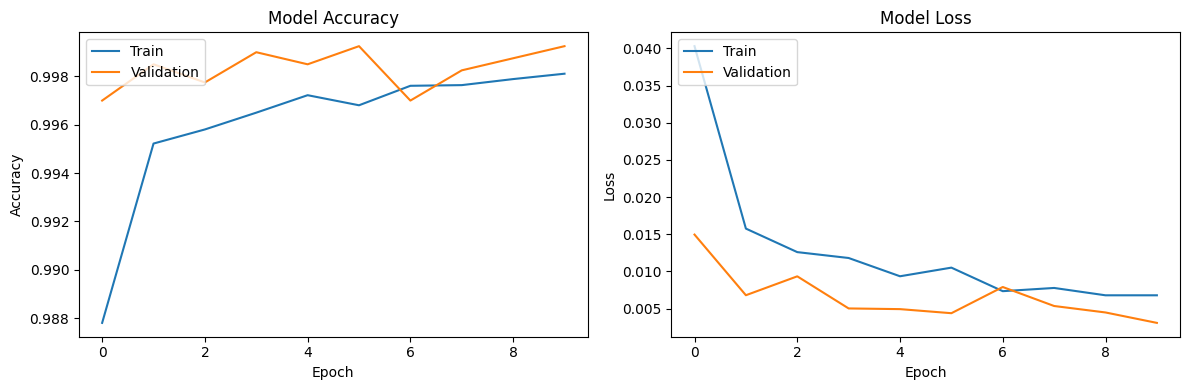

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Training History
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()



In [23]:
# Confusion Matrix
train_genarator.reset()  # Reset the generator to the beginning
y_true_train = train_genarator.classes
y_pred_probabilities_train = model.predict(train_genarator, steps=len(train_genarator))
y_pred_train = np.argmax(y_pred_probabilities_train, axis=1)

validation_generator.reset()  # Reset the generator to the beginning
y_true_val = validation_generator.classes
y_pred_probabilities_val = model.predict(validation_generator, steps=len(validation_generator))
y_pred_val = np.argmax(y_pred_probabilities_val, axis=1)

# Combine training and validation results
y_true = np.concatenate([y_true_train, y_true_val])
y_pred = np.concatenate([y_pred_train, y_pred_val])



63/63 [==============================] - 17s 276ms/step


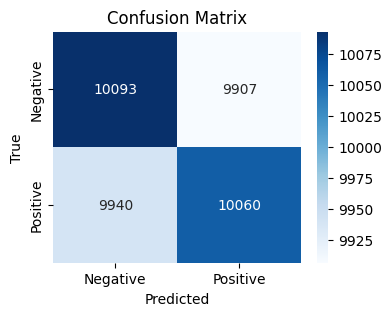

In [25]:
# Plot Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=train_genarator.class_indices.keys(), yticklabels=train_genarator.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


